# IMPORT

In [46]:
import os
import cv2
import mediapipe as mp
import numpy as np
import glob
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import time
from threading import Thread
import pickle
from scipy import signal

# FUNCTION

In [5]:
def calc_l(a1, a2):
    a1 = np.array(a1)
    a2 = np.array(a2)
    return np.sqrt(((a1-a2)**2).sum())

In [6]:
def calc_angles(l):
    return np.arccos((l[0]**2 + l[1]**2 - l[2]**2)/(2 * l[0] * l[1]))/np.pi*180.

In [7]:
def slope(a, b):
    sub = np.array(a)-np.array(b)
    return np.abs(sub[1]/sub[0])

In [8]:
def calc_l3(kp):
    l = {}
    l['Leftarmpitangle'] = [calc_l(kp['LEFT_SHOULDER'], kp['LEFT_ELBOW']),
                            calc_l(kp['LEFT_SHOULDER'], kp['LEFT_HIP']),
                            calc_l(kp['LEFT_ELBOW'], kp['LEFT_HIP'])]

    l['Rightarmpitangle'] = [calc_l(kp['RIGHT_SHOULDER'], kp['RIGHT_ELBOW']),
                            calc_l(kp['RIGHT_SHOULDER'], kp['RIGHT_HIP']),
                            calc_l(kp['RIGHT_ELBOW'], kp['RIGHT_HIP'])]

    l['Leftshoulderangle'] = [calc_l(kp['LEFT_SHOULDER'], kp['RIGHT_SHOULDER']),
                            calc_l(kp['LEFT_SHOULDER'], kp['LEFT_HIP']),
                            calc_l(kp['RIGHT_SHOULDER'], kp['LEFT_HIP'])]

    l['Rightshoulderangle'] = [calc_l(kp['RIGHT_SHOULDER'], kp['LEFT_SHOULDER']),
                            calc_l(kp['RIGHT_SHOULDER'], kp['RIGHT_HIP']),
                            calc_l(kp['LEFT_SHOULDER'], kp['RIGHT_HIP'])]

    l['Leftelbowangle'] = [calc_l(kp['LEFT_ELBOW'], kp['LEFT_SHOULDER']),
                        calc_l(kp['LEFT_ELBOW'], kp['LEFT_WRIST']),
                        calc_l(kp['LEFT_SHOULDER'], kp['LEFT_WRIST'])]

    l['Rightelbowangle'] = [calc_l(kp['RIGHT_ELBOW'], kp['RIGHT_SHOULDER']),
                            calc_l(kp['RIGHT_ELBOW'], kp['RIGHT_WRIST']),
                            calc_l(kp['RIGHT_SHOULDER'], kp['RIGHT_WRIST'])]

    l['Lefthipangle'] = [calc_l(kp['LEFT_HIP'], kp['RIGHT_HIP']),
                        calc_l(kp['LEFT_HIP'], kp['LEFT_SHOULDER']),
                        calc_l(kp['RIGHT_HIP'], kp['LEFT_SHOULDER'])]

    l['Righthipangle'] = [calc_l(kp['RIGHT_HIP'], kp['LEFT_HIP']),
                        calc_l(kp['RIGHT_HIP'], kp['RIGHT_SHOULDER']),
                        calc_l(kp['LEFT_HIP'], kp['RIGHT_SHOULDER'])]

    l['Leftgroinangle'] = [calc_l(kp['LEFT_HIP'], kp['LEFT_KNEE']),
                        calc_l(kp['LEFT_HIP'], kp['LEFT_ANKLE']),
                        calc_l(kp['LEFT_KNEE'], kp['LEFT_ANKLE'])]

    l['Rightgroinangle'] = [calc_l(kp['RIGHT_HIP'], kp['RIGHT_KNEE']),
                            calc_l(kp['RIGHT_HIP'], kp['RIGHT_ANKLE']),
                            calc_l(kp['RIGHT_KNEE'], kp['RIGHT_ANKLE'])]
                            
    l['Leftkneeangle'] = [calc_l(kp['LEFT_KNEE'], kp['LEFT_ANKLE']),
                        calc_l(kp['LEFT_KNEE'], kp['LEFT_HIP']),
                        calc_l(kp['LEFT_ANKLE'], kp['LEFT_HIP'])]

    l['Rightkneeangle'] = [calc_l(kp['RIGHT_KNEE'], kp['RIGHT_ANKLE']),
                        calc_l(kp['RIGHT_KNEE'], kp['RIGHT_HIP']),
                        calc_l(kp['RIGHT_ANKLE'], kp['RIGHT_HIP'])]
    return l

# MAKE DATA
Get keypoints and convert to angles<br>

In [28]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
# For static images:
IMAGE_FILES = glob.glob('val/*/*')
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  angles = dict(
      Leftarmpitangle=[],
      Rightarmpitangle=[],
      Leftshoulderangle=[],
      Rightshoulderangle=[],
      Leftelbowangle=[],
      Rightelbowangle=[],
      Lefthipangle=[],
      Righthipangle=[],
      Leftgroinangle=[],
      Rightgroinangle=[],
      Leftkneeangle=[],
      Rightkneeangle=[],
      Slope = [],
      action = [])
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue
    # print(
    #     f'Nose coordinates: ('
    #     f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
    #     f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
    # )
    kp = {}
    for pos in ['LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE']:
        kp[pos] = [results.pose_landmarks.landmark[getattr(mp_pose.PoseLandmark, pos)].x * image_width,
                  results.pose_landmarks.landmark[getattr(mp_pose.PoseLandmark, pos)].y * image_height]

    l = {}
    l['Leftarmpitangle'] = [calc_l(kp['LEFT_SHOULDER'], kp['LEFT_ELBOW']),
                            calc_l(kp['LEFT_SHOULDER'], kp['LEFT_HIP']),
                            calc_l(kp['LEFT_ELBOW'], kp['LEFT_HIP'])]

    l['Rightarmpitangle'] = [calc_l(kp['RIGHT_SHOULDER'], kp['RIGHT_ELBOW']),
                            calc_l(kp['RIGHT_SHOULDER'], kp['RIGHT_HIP']),
                            calc_l(kp['RIGHT_ELBOW'], kp['RIGHT_HIP'])]

    l['Leftshoulderangle'] = [calc_l(kp['LEFT_SHOULDER'], kp['RIGHT_SHOULDER']),
                              calc_l(kp['LEFT_SHOULDER'], kp['LEFT_HIP']),
                              calc_l(kp['RIGHT_SHOULDER'], kp['LEFT_HIP'])]

    l['Rightshoulderangle'] = [calc_l(kp['RIGHT_SHOULDER'], kp['LEFT_SHOULDER']),
                              calc_l(kp['RIGHT_SHOULDER'], kp['RIGHT_HIP']),
                              calc_l(kp['LEFT_SHOULDER'], kp['RIGHT_HIP'])]

    l['Leftelbowangle'] = [calc_l(kp['LEFT_ELBOW'], kp['LEFT_SHOULDER']),
                          calc_l(kp['LEFT_ELBOW'], kp['LEFT_WRIST']),
                          calc_l(kp['LEFT_SHOULDER'], kp['LEFT_WRIST'])]

    l['Rightelbowangle'] = [calc_l(kp['RIGHT_ELBOW'], kp['RIGHT_SHOULDER']),
                            calc_l(kp['RIGHT_ELBOW'], kp['RIGHT_WRIST']),
                            calc_l(kp['RIGHT_SHOULDER'], kp['RIGHT_WRIST'])]

    l['Lefthipangle'] = [calc_l(kp['LEFT_HIP'], kp['RIGHT_HIP']),
                        calc_l(kp['LEFT_HIP'], kp['LEFT_SHOULDER']),
                        calc_l(kp['RIGHT_HIP'], kp['LEFT_SHOULDER'])]

    l['Righthipangle'] = [calc_l(kp['RIGHT_HIP'], kp['LEFT_HIP']),
                          calc_l(kp['RIGHT_HIP'], kp['RIGHT_SHOULDER']),
                          calc_l(kp['LEFT_HIP'], kp['RIGHT_SHOULDER'])]

    l['Leftgroinangle'] = [calc_l(kp['LEFT_HIP'], kp['LEFT_KNEE']),
                          calc_l(kp['LEFT_HIP'], kp['LEFT_ANKLE']),
                          calc_l(kp['LEFT_KNEE'], kp['LEFT_ANKLE'])]

    l['Rightgroinangle'] = [calc_l(kp['RIGHT_HIP'], kp['RIGHT_KNEE']),
                            calc_l(kp['RIGHT_HIP'], kp['RIGHT_ANKLE']),
                            calc_l(kp['RIGHT_KNEE'], kp['RIGHT_ANKLE'])]
                            
    l['Leftkneeangle'] = [calc_l(kp['LEFT_KNEE'], kp['LEFT_ANKLE']),
                          calc_l(kp['LEFT_KNEE'], kp['LEFT_HIP']),
                          calc_l(kp['LEFT_ANKLE'], kp['LEFT_HIP'])]

    l['Rightkneeangle'] = [calc_l(kp['RIGHT_KNEE'], kp['RIGHT_ANKLE']),
                          calc_l(kp['RIGHT_KNEE'], kp['RIGHT_HIP']),
                          calc_l(kp['RIGHT_ANKLE'], kp['RIGHT_HIP'])]
    s = np.min([slope(kp['LEFT_SHOULDER'], kp['LEFT_ANKLE']),
            slope(kp['RIGHT_SHOULDER'], kp['RIGHT_ANKLE'])])
    # print(idx)
    for k in l.keys():
        angles[k].append(calc_angles(l[k]))
    angles['action'].append(file.split('\\')[1])
    angles['Slope'].append(s)
    # print(file.split('/'))

  df = pd.DataFrame(angles)
  df.drop_duplicates(df.columns[:-1], keep=False, inplace=True)
  df.to_csv('mediapile_collect_val.csv', index=False)
    # df.head()
    # print(angles)
    # Draw pose landmarks on the image.

    # mp_drawing.draw_landmarks(
    #     image,
    #     results.pose_landmarks,
    #     mp_pose.POSE_CONNECTIONS,
    #     landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
  #   image = cv2.resize(image, (512, 512))
  #   cv2.putText(image, str(s), (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
  #   cv2.imshow('/tmp/annotated_image' + str(idx) + '.png', image)
  #   k = cv2.waitKey(0)
  #   if k in [113, 27]:
  #       if k==27:
  #           break
  #   cv2.destroyAllWindows()
  # cv2.destroyAllWindows()


# READ DATA

In [11]:
df_train = pd.read_csv('data/collect_train.csv')
df_val = pd.read_csv('data/collect_val.csv')

# df = df.drop([df.columns[0]], axis=1)

In [12]:
#train
df_squat_train = df_train[df_train.action.isin(['squat', 'squatup'])].reset_index(drop=True)
df_push_train = df_train[df_train.action.isin(['pushdown', 'pushup'])].reset_index(drop=True)
df_pull_train = df_train[df_train.action.isin(['pulldown', 'pullup'])].reset_index(drop=True)
#val
df_squat_val = df_val[df_val.action.isin(['squat', 'squatup'])].reset_index(drop=True)
df_push_val = df_val[df_val.action.isin(['pushdown', 'pushup'])].reset_index(drop=True)
df_pull_val = df_val[df_val.action.isin(['pulldown', 'pullup'])].reset_index(drop=True)

# SQUAT

In [13]:
#Train
print(df_squat_train.shape)
df_squat_train_dup = df_squat_train.drop_duplicates(df_squat_train.columns[:-1],keep=False)
df_squat_train_for_pca = df_squat_train_dup.drop(['action'], axis=1)
print(df_squat_train_dup.shape)
# dup.where(lambda x: x == True).dropna()
print(df_squat_val.shape)
df_squat_val_dup = df_squat_val.drop_duplicates(df_squat_val.columns[:-1],keep=False)
df_squat_val_for_pca = df_squat_val_dup.drop(['action'], axis=1)
print(df_squat_val_dup.shape)

(703, 14)
(703, 14)
(110, 14)
(110, 14)


In [14]:
pca_squat = PCA(n_components=4)
principalComponents_squat_train = pca_squat.fit_transform(df_squat_train_for_pca)
principalDf_squat_train = pd.DataFrame(data = principalComponents_squat_train
             , columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])

principalComponents_squat_val = pca_squat.transform(df_squat_val_for_pca)
principalDf_squat_val = pd.DataFrame(data = principalComponents_squat_val
             , columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])           

In [15]:
finalDf_squat_train = pd.concat([principalDf_squat_train, df_squat_train_dup[['action']]], axis=1)
finalDf_squat_val = pd.concat([principalDf_squat_val, df_squat_val_dup[['action']]], axis=1)
print(finalDf_squat_train.shape)
print(finalDf_squat_val.shape)

(703, 5)
(110, 5)


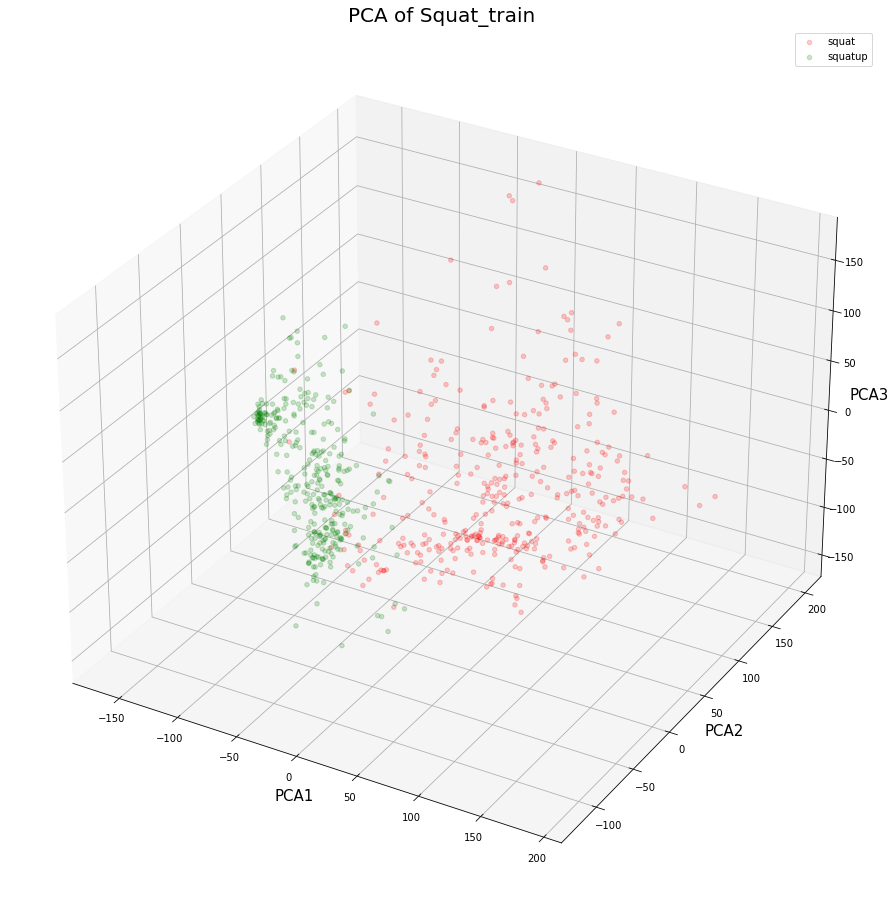

In [16]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('PCA1', fontsize = 15)
ax.set_ylabel('PCA2', fontsize = 15)
ax.set_zlabel('PCA3', fontsize = 15)

ax.set_title('PCA of Squat_train', fontsize = 20)
targets = ['squat', 'squatup']
colors = ['r','g']
for target, color in zip(targets,colors):
    # if target == 'stand': continue
    indicesToKeep = finalDf_squat_train['action'] == target
    # print(finalDf.loc[indicesToKeep, :])
    ax.scatter(finalDf_squat_train.loc[indicesToKeep, 'PCA1']
               , finalDf_squat_train.loc[indicesToKeep, 'PCA2']
               , finalDf_squat_train.loc[indicesToKeep, 'PCA3']
               , c = color
               , alpha = 0.2)
ax.legend(targets)
ax.grid()

In [17]:
lbl_squat = LabelEncoder()
finalDf_squat_train[['action']] = finalDf_squat_train[['action']].apply(lbl_squat.fit_transform)
finalDf_squat_val[['action']] = finalDf_squat_val[['action']].apply(lbl_squat.transform)

## SVM

In [21]:
#Train
X_squat_train = finalDf_squat_train.values[:,:-1]
# X_squat_train = df_squat_train_for_pca.values
Y_squat_train = finalDf_squat_train.values[:,-1]
#Val
X_squat_val = finalDf_squat_val.values[:,:-1]
# X_squat_val = df_squat_val_for_pca.values
Y_squat_val = finalDf_squat_val.values[:,-1]

print(finalDf_squat_train.shape)
print(finalDf_squat_val.shape)


(703, 5)
(110, 5)


In [22]:
svm_squat = SVC(probability=True)
svm_squat.fit(X_squat_train,Y_squat_train)
print(svm_squat.score(X_squat_train, Y_squat_train))
print(svm_squat.score(X_squat_val, Y_squat_val))

0.972972972972973
1.0


In [20]:
svm_squat = SVC(probability=True)
svm_squat.fit(X_squat_train,Y_squat_train)
print(svm_squat.score(X_squat_train, Y_squat_train))
print(svm_squat.score(X_squat_val, Y_squat_val))

0.9772403982930299
0.9636363636363636


# PUSH

In [23]:
#Train
print(df_push_train.shape)
df_push_train_dup = df_push_train.drop_duplicates(df_push_train.columns[:-1],keep=False)
df_push_train_for_pca = df_push_train_dup.drop(['action'], axis=1)
print(df_push_train_dup.shape)
# dup.where(lambda x: x == True).dropna()
print(df_push_val.shape)
df_push_val_dup = df_push_val.drop_duplicates(df_push_val.columns[:-1],keep=False)
df_push_val_for_pca = df_push_val_dup.drop(['action'], axis=1)
print(df_push_val_dup.shape)

(982, 14)
(982, 14)
(108, 14)
(108, 14)


In [24]:
pca_push = PCA(n_components=4)
principalComponents_push_train = pca_push.fit_transform(df_push_train_for_pca)
principalDf_push_train = pd.DataFrame(data = principalComponents_push_train
             , columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])

principalComponents_push_val = pca_push.transform(df_push_val_for_pca)
principalDf_push_val = pd.DataFrame(data = principalComponents_push_val
             , columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])           

In [25]:
finalDf_push_train = pd.concat([principalDf_push_train, df_push_train_dup[['action']]], axis=1)
finalDf_push_val = pd.concat([principalDf_push_val, df_push_val_dup[['action']]], axis=1)
print(finalDf_push_train.shape)
print(finalDf_push_val.shape)

(982, 5)
(108, 5)


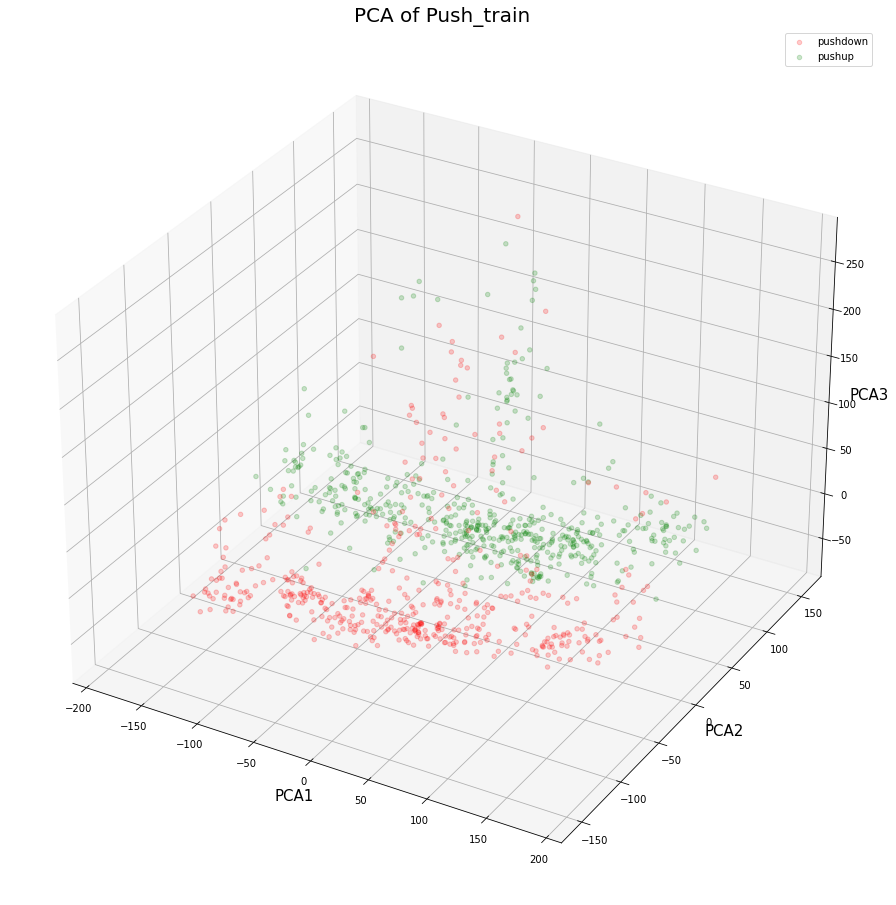

In [26]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('PCA1', fontsize = 15)
ax.set_ylabel('PCA2', fontsize = 15)
ax.set_zlabel('PCA3', fontsize = 15)

ax.set_title('PCA of Push_train', fontsize = 20)
targets = finalDf_push_train.action.unique()
colors = ['r','g']
for target, color in zip(targets,colors):
    # if target == 'stand': continue
    indicesToKeep = finalDf_push_train['action'] == target
    # print(finalDf.loc[indicesToKeep, :])
    ax.scatter(finalDf_push_train.loc[indicesToKeep, 'PCA1']
               , finalDf_push_train.loc[indicesToKeep, 'PCA2']
               , finalDf_push_train.loc[indicesToKeep, 'PCA3']
               , c = color
               , alpha = 0.2)
ax.legend(targets)
ax.grid()

In [27]:
lbl_push = LabelEncoder()
finalDf_push_train[['action']] = finalDf_push_train[['action']].apply(lbl_push.fit_transform)
finalDf_push_val[['action']] = finalDf_push_val[['action']].apply(lbl_push.transform)

In [28]:
#Train
X_push_train = finalDf_push_train.values[:,:-1]
Y_push_train = finalDf_push_train.values[:,-1]
#Val
X_push_val = finalDf_push_val.values[:,:-1]
Y_push_val = finalDf_push_val.values[:,-1]

print(finalDf_push_train.shape)
print(finalDf_push_val.shape)

(982, 5)
(108, 5)


In [29]:
svm_push = SVC(probability=True)
svm_push.fit(X_push_train,Y_push_train)
print(svm_push.score(X_push_train, Y_push_train))
print(svm_push.score(X_push_val, Y_push_val))

0.9775967413441955
0.9814814814814815


# PULL

In [30]:
#Train
print(df_pull_train.shape)
df_pull_train_dup = df_pull_train.drop_duplicates(df_pull_train.columns[:-1],keep=False)
df_pull_train_for_pca = df_pull_train_dup.drop(['action'], axis=1)
print(df_pull_train_dup.shape)
# dup.where(lambda x: x == True).dropna()
print(df_pull_val.shape)
df_pull_val_dup = df_pull_val.drop_duplicates(df_pull_val.columns[:-1],keep=False)
df_pull_val_for_pca = df_pull_val_dup.drop(['action'], axis=1)
print(df_pull_val_dup.shape)

(770, 14)
(770, 14)
(127, 14)
(127, 14)


In [31]:
pca_pull = PCA(n_components=4)
principalComponents_pull_train = pca_pull.fit_transform(df_pull_train_for_pca)
principalDf_pull_train = pd.DataFrame(data = principalComponents_pull_train
             , columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])

principalComponents_pull_val = pca_pull.transform(df_pull_val_for_pca)
principalDf_pull_val = pd.DataFrame(data = principalComponents_pull_val
             , columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])

In [32]:
finalDf_pull_train = pd.concat([principalDf_pull_train, df_pull_train_dup[['action']]], axis=1)
finalDf_pull_val = pd.concat([principalDf_pull_val, df_pull_val_dup[['action']]], axis=1)
print(finalDf_pull_train.shape)
print(finalDf_pull_val.shape)

(770, 5)
(127, 5)


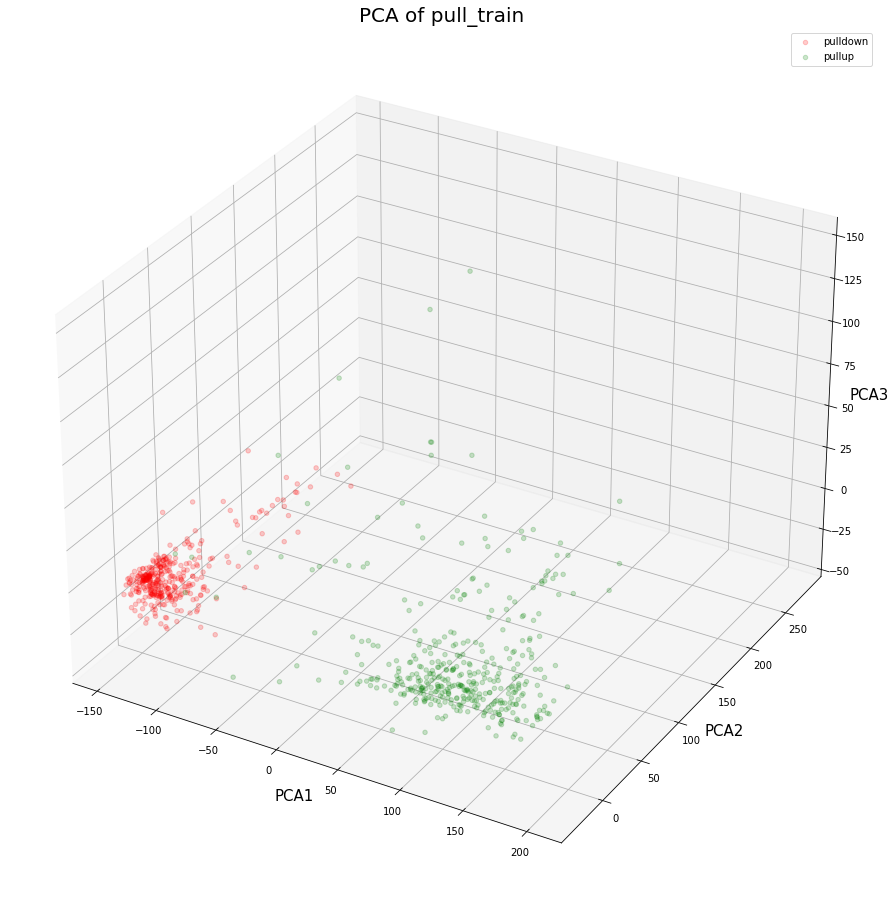

In [33]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('PCA1', fontsize = 15)
ax.set_ylabel('PCA2', fontsize = 15)
ax.set_zlabel('PCA3', fontsize = 15)

ax.set_title('PCA of pull_train', fontsize = 20)
targets = finalDf_pull_train.action.unique()
colors = ['r','g']
for target, color in zip(targets,colors):
    # if target == 'stand': continue
    indicesToKeep = finalDf_pull_train['action'] == target
    # print(finalDf.loc[indicesToKeep, :])
    ax.scatter(finalDf_pull_train.loc[indicesToKeep, 'PCA1']
               , finalDf_pull_train.loc[indicesToKeep, 'PCA2']
               , finalDf_pull_train.loc[indicesToKeep, 'PCA3']
               , c = color
               , alpha = 0.2)
ax.legend(targets)
ax.grid()

In [34]:
lbl_pull = LabelEncoder()
finalDf_pull_train[['action']] = finalDf_pull_train[['action']].apply(lbl_pull.fit_transform)
finalDf_pull_val[['action']] = finalDf_pull_val[['action']].apply(lbl_pull.transform)

In [35]:
#Train
X_pull_train = finalDf_pull_train.values[:,:-1]
Y_pull_train = finalDf_pull_train.values[:,-1]
#Val
X_pull_val = finalDf_pull_val.values[:,:-1]
Y_pull_val = finalDf_pull_val.values[:,-1]

print(finalDf_pull_train.shape)
print(finalDf_pull_val.shape)

(770, 5)
(127, 5)


In [36]:
svm_pull = SVC(probability=True)
svm_pull.fit(X_pull_train,Y_pull_train)
print(svm_pull.score(X_pull_train, Y_pull_train))
print(svm_pull.score(X_pull_val, Y_pull_val))

0.9935064935064936
0.9921259842519685


# ALL
3 classes

In [38]:
#Train
print(df_train.shape)
df_all_train_dup = df_train.drop_duplicates(df_train.columns[:-1],keep=False)
df_all_train_dup['action'] = df_all_train_dup.action.replace(df_all_train_dup.action.unique()[0:5:2],df_all_train_dup.action.unique()[1:6:2])
df_all_train_for_pca = df_all_train_dup.drop(['action'], axis=1)
print(df_all_train_dup.shape)
# dup.where(lambda x: x == True).dropna()
print(df_val.shape)
df_all_val_dup = df_val.drop_duplicates(df_val.columns[:-1],keep=False)
df_all_val_dup['action'] = df_all_val_dup.action.replace(df_all_val_dup.action.unique()[0:5:2],df_all_val_dup.action.unique()[1:6:2])
df_all_val_for_pca = df_all_val_dup.drop(['action'], axis=1)
print(df_all_val_dup.shape)

(2455, 14)
(2455, 14)
(345, 14)
(345, 14)


In [39]:
pca_all = PCA(n_components=4)
principalComponents_all_train = pca_all.fit_transform(df_all_train_for_pca)
principalDf_all_train = pd.DataFrame(data = principalComponents_all_train
             , columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])

principalComponents_all_val = pca_all.transform(df_all_val_for_pca)
principalDf_all_val = pd.DataFrame(data = principalComponents_all_val
             , columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])           

In [40]:
finalDf_all_train = pd.concat([principalDf_all_train, df_all_train_dup[['action']]], axis=1)
finalDf_all_val = pd.concat([principalDf_all_val, df_all_val_dup[['action']]], axis=1)
print(finalDf_all_train.shape)
print(finalDf_all_val.shape)

(2455, 5)
(345, 5)


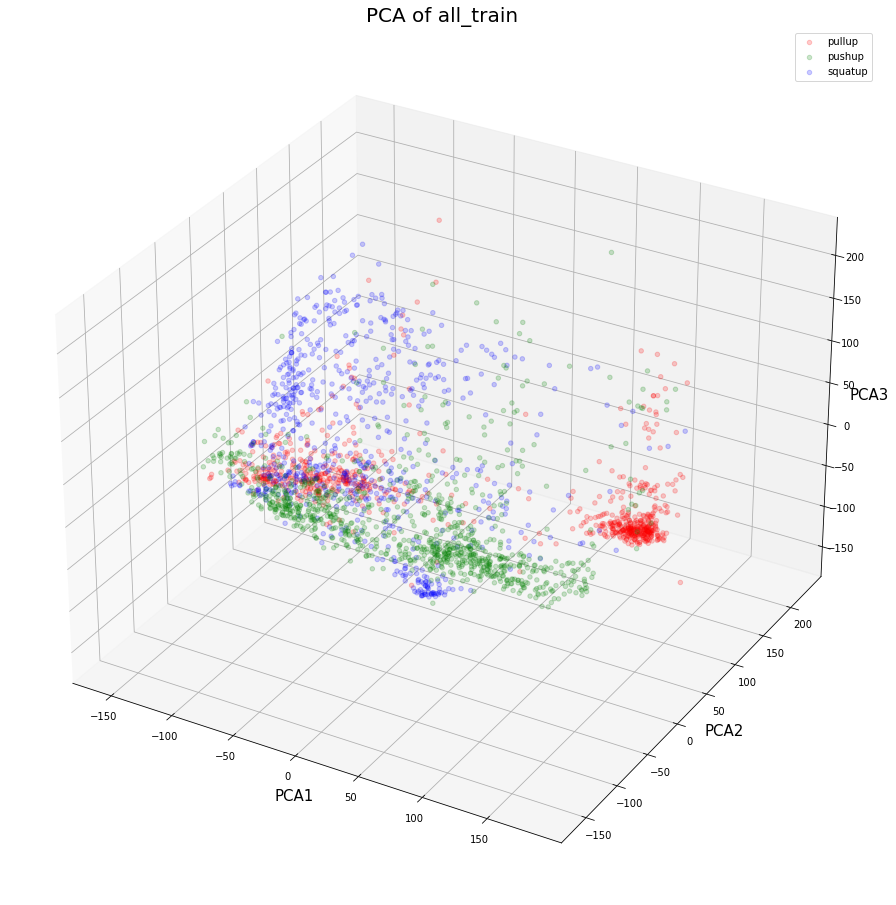

In [41]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('PCA1', fontsize = 15)
ax.set_ylabel('PCA2', fontsize = 15)
ax.set_zlabel('PCA3', fontsize = 15)

ax.set_title('PCA of all_train', fontsize = 20)
targets = finalDf_all_train.action.unique()
colors = ['r','g','b']
for target, color in zip(targets,colors):
    # if target == 'stand': continue
    indicesToKeep = finalDf_all_train['action'] == target
    # print(finalDf.loc[indicesToKeep, :])
    ax.scatter(finalDf_all_train.loc[indicesToKeep, 'PCA1']
               , finalDf_all_train.loc[indicesToKeep, 'PCA2']
               , finalDf_all_train.loc[indicesToKeep, 'PCA3']
               , c = color
               , alpha = 0.2)
ax.legend(targets)
ax.grid()

In [42]:
lbl_all = LabelEncoder()
finalDf_all_train[['action']] = finalDf_all_train[['action']].apply(lbl_all.fit_transform)
finalDf_all_val[['action']] = finalDf_all_val[['action']].apply(lbl_all.transform)

In [43]:
#Train
X_all_train = finalDf_all_train.values[:,:-1]
# X_all_train = df_all_train_for_pca.values
Y_all_train = finalDf_all_train.values[:,-1]
#Val
X_all_val = finalDf_all_val.values[:,:-1]
# X_all_val = df_all_val_for_pca.values
Y_all_val = finalDf_all_val.values[:,-1]

print(X_all_train.shape)
print(X_all_val.shape)

(2455, 4)
(345, 4)


## KNN GridsearchVN

In [39]:
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11]}

In [ ]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=3)
grid.fit(X_all_train,Y_all_train)
print(grid.best_estimator_)

In [41]:
svm = KNeighborsClassifier(n_neighbors=9)
svm.fit(X_all_train, Y_all_train)
print(svm.score(X_all_train, Y_all_train))
print(svm.score(X_all_val, Y_all_val))

0.8839103869653768
0.8


## RANDOMFOREST

In [86]:
param_grid = { 
    'n_estimators': [10, 30, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [93]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_all_train, Y_all_train)
print(CV_rfc.best_params_)
# print(dt.score(xtrain,ytrain))
# print(dt.score(xtest,ytest))

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}


Tất cả feature: RandomForestClassifier(criterion='gini', max_depth=7, max_features='auto', n_estimators=100)

In [103]:
rf = RandomForestClassifier(criterion='gini', max_depth=7, max_features='auto', n_estimators=100)
rf.fit(X_all_train, Y_all_train)
print(rf.score(X_all_train, Y_all_train))
print(rf.score(X_all_val, Y_all_val))

0.9686354378818737
0.9130434782608695


PCA4: RandomForestClassifier(criterion='gini', max_depth=6, max_features='log2', n_estimators=10)

In [89]:
rf = RandomForestClassifier(criterion='gini', max_depth=6, max_features='log2', n_estimators=10)
rf.fit(X_all_train, Y_all_train)
print(rf.score(X_all_train, Y_all_train))
print(rf.score(X_all_val, Y_all_val))

0.8582484725050916
0.8405797101449275


## Save model

In [106]:
#SQUAT
filename = 'model_saved/pca_squat.sav'
pickle.dump(pca_squat, open(filename, 'wb'))
filename = 'model_saved/svm_squat.sav'
pickle.dump(svm_squat, open(filename, 'wb'))
#PUSH
filename = 'model_saved/pca_push.sav'
pickle.dump(pca_push, open(filename, 'wb'))
filename = 'model_saved/svm_push.sav'
pickle.dump(svm_push, open(filename, 'wb'))
#PUSH
filename = 'model_saved/pca_pull.sav'
pickle.dump(pca_pull, open(filename, 'wb'))
filename = 'model_saved/svm_pull.sav'
pickle.dump(svm_pull, open(filename, 'wb'))
#PUSH
filename = 'model_saved/pca_all.sav'
pickle.dump(pca_all, open(filename, 'wb'))
filename = 'model_saved/rf_all.sav'
pickle.dump(rf, open(filename, 'wb'))

# TEST

In [12]:
# Initilazion
load_pca_pull = pickle.load(open('model_saved/pca_pull.sav', 'rb'))
load_pca_push = pickle.load(open('model_saved/pca_push.sav', 'rb'))
load_pca_squat = pickle.load(open('model_saved/pca_squat.sav', 'rb'))
load_pca_all = pickle.load(open('model_saved/pca_all.sav', 'rb'))

load_svm_pull = pickle.load(open('model_saved/svm_pull.sav', 'rb'))
load_svm_push = pickle.load(open('model_saved/svm_push.sav', 'rb'))
load_svm_squat = pickle.load(open('model_saved/svm_squat.sav', 'rb'))

load_rf_all = pickle.load(open('model_saved/rf_all.sav', 'rb'))

model_dict = dict(
    pca_pull = load_pca_pull,
    pca_push = load_pca_push,
    pca_squat = load_pca_squat,
    pca_all = load_pca_all,
    svm_pull = load_svm_pull,
    svm_push = load_svm_push,
    svm_squat = load_svm_squat,
    rf_all = load_rf_all
)

kp_name = [
    'LEFT_SHOULDER', 
    'RIGHT_SHOULDER', 
    'LEFT_ELBOW', 
    'RIGHT_ELBOW', 
    'LEFT_HIP', 
    'RIGHT_HIP', 
    'LEFT_WRIST', 
    'RIGHT_WRIST', 
    'LEFT_KNEE', 
    'RIGHT_KNEE', 
    'LEFT_ANKLE', 
    'RIGHT_ANKLE'
]
mp_pose = mp.solutions.pose
count = 0

In [126]:
def classification(image, model_dict, kp_name=kp_name, pose=None):
    # PCA
    pca_squat = model_dict['pca_squat']
    pca_push = model_dict['pca_push']
    pca_pull = model_dict['pca_pull']
    pca_all = model_dict['pca_all']

    PCA = [pca_pull, pca_push, pca_squat]
    # SVM
    svm_squat = model_dict['svm_squat']
    svm_push = model_dict['svm_push']
    svm_pull = model_dict['svm_pull']

    SVM = [svm_squat, svm_push, svm_squat]
    # SVM
    rf_all = model_dict['rf_all']
    #Process image
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image.shape
    results = pose.process(image)
    if results.pose_landmarks:
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        kp = {}
        for pos in kp_name:
            kp[pos] = [results.pose_landmarks.landmark[getattr(mp_pose.PoseLandmark, pos)].x * image_width,
                      results.pose_landmarks.landmark[getattr(mp_pose.PoseLandmark, pos)].y * image_height]

        l = calc_l3(kp)
        s = np.min([slope(kp['LEFT_SHOULDER'], kp['LEFT_ANKLE']),
                    slope(kp['RIGHT_SHOULDER'], kp['RIGHT_ANKLE'])])
        angle = np.array([])
        for k in l.keys():
            angle = np.append(angle, calc_angles(l[k]))
        angle = np.append(angle, s)
        prob_act = rf_all.predict_proba([angle])[0]
        prob_choose = prob_act>np.array([0.8, 0.8, 0.42])
        act = prob_choose.argmax()
        prob = SVM[act].predict_proba(PCA[act].transform([angle]))[0][0]
        if act==0: prob = 1-prob
        show = image.copy()
        if prob_choose[act]:
            # print('passs')
            return act, prob
        else:
            # print('not passs')
            return 3, 0
    else:
        return 3, 0.

In [127]:
class RepetitionCounter():
    def __init__(self, enter_threshold=0.8, exit_threshold=0.2):
        self._enter_threshold = enter_threshold
        self._exit_threshold = exit_threshold
        self._pose_entered = False
        self._n_repeats = 0
    @property
    def n_repeats(self):
        return self._n_repeats
    def fit(self, data):
        pose_confidence = 0.0
        if data is not None:
            pose_confidence = data
        if not self._pose_entered:
            self._pose_entered = pose_confidence > self._enter_threshold
            return self._n_repeats
        if pose_confidence < self._exit_threshold:
            self._n_repeats += 1
            self._pose_entered = False
        return self._n_repeats

In [137]:
prob_s = np.array([])
prob_p = np.array([])
actt = np.array([])

prob_aa = dict(SQUAT=prob_s, PULL=prob_s, actt = actt)

rpt_pull = RepetitionCounter(0.8, 0.3)
rpt_push = RepetitionCounter(0.7, 0.3)
rpt_squat = RepetitionCounter(0.7, 0.3)
rpt = dict(PULL = rpt_pull, PUSH = rpt_push, SQUAT = rpt_squat)

cap = cv2.VideoCapture('../push_squat_luc.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
prob_list = np.array([0])
filtered = np.array([0])
count=0
dict_count = dict(SQUAT = 0, PUSH = 0, PULL = 0)
list_act = ['PULL', 'PUSH', 'SQUAT', 'UNKNOWN']
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    start = time.time()
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            break
        image_height, image_width, _ = image.shape
        if count%3==0:
            act, prob = classification(image, model_dict, kp_name, pose)
            # if act != 3:
            # prob_list = np.append(prob_list, prob)
            if act in [0, 2]:
                if prob<0.5:
                    rpt[list_act[0]].fit(prob)
                    rpt[list_act[2]].fit(prob)
                    dict_count[list_act[0]] = rpt[list_act[0]].n_repeats
                    dict_count[list_act[2]] = rpt[list_act[2]].n_repeats
                    prob_aa[list_act[0]] = np.append(prob_aa[list_act[0]], prob)
                    prob_aa[list_act[2]] = np.append(prob_aa[list_act[2]], prob)
                    prob_aa['actt'] = np.append(prob_aa['actt'], act)
                elif prob>0.5:
                    prob_aa['actt'] = np.append(prob_aa['actt'], act)
                    prob_aa[list_act[act]] = np.append(prob_aa[list_act[act]], prob)
                    prob_aa[list_act[2-act]] = np.append(prob_aa[list_act[2-act]], 0)

                    rpt[list_act[act]].fit(prob)
                    dict_count[list_act[act]] = rpt[list_act[act]].n_repeats
            elif act==1:
                rpt[list_act[act]].fit(prob)
                dict_count[list_act[act]] = rpt[list_act[act]].n_repeats

        count = count+1
        show = cv2.resize(image, (image_width//2, image_height//2))
        for ind, (k,v) in enumerate(dict_count.items()):
            cv2.putText(show, k + ': ' + str(v), (0,50*(ind+1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow('show', show)
        if cv2.waitKey(5) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

Ignoring empty camera frame.
